# RTEM Hackathon notebook

## Import standard libraries

In [1]:
import pandas as pd
import numpy as np

## Import RTEM libraries

In [ ]:
# Install onboard client to python, uncomment and run once
'''
!pip install onboard.client
'''

In [2]:
from onboard.client import RtemClient
from onboard.client.dataframes import points_df_from_streaming_timeseries
from onboard.client.models import PointSelector, TimeseriesQuery, PointData
from datetime import datetime, timezone, timedelta
from typing import List
import pytz

## Load secret

In [3]:
# Read secret from /secrets/ folder
with open('secrets/secrets.txt') as f:
    secret = f.readlines()[0]

# Setup client
client = RtemClient(api_key=secret)

In [4]:
all_buildings = list(pd.DataFrame(client.get_all_buildings())['id'])
print(list(pd.DataFrame(client.get_all_buildings())['id'])) # returns list of buildings that you have access to (you may not have 'Laboratory' in your set)
print(len(all_buildings))

[441, 140, 191, 231, 248, 249, 434, 271, 285, 297, 322, 317, 419, 375, 470, 426, 423, 439, 314, 467, 455, 105, 107, 488, 445, 417, 460, 472, 442, 118, 477, 443, 468, 438, 478, 395, 485, 418, 450, 473, 230, 127, 469, 100, 452, 461, 489, 99, 98, 479, 474, 466, 134, 131, 130, 420, 136, 475, 373, 176, 217, 490, 103, 421, 476, 142, 462, 422, 503, 385, 471, 108, 143, 454, 279, 481, 101, 491, 492, 111, 109, 451, 258, 112, 440, 483, 113, 114, 119, 200, 117, 121, 120, 122, 484, 110, 151, 153, 129, 148, 115, 116, 125, 126, 486, 465, 132, 124, 135, 487, 138, 137, 128, 141, 145, 147, 149, 171, 146, 162, 163, 165, 168, 172, 173, 170, 167, 160, 174, 175, 169, 164, 179, 197, 139, 192, 194, 177, 181, 183, 185, 187, 188, 190, 180, 206, 207, 201, 202, 205, 210, 215, 216, 220, 224, 225, 226, 236, 234, 232, 246, 250, 252, 253, 256, 247, 259, 242, 263, 264, 272, 274, 275, 277, 278, 282, 265, 286, 288, 294, 296, 298, 301, 302, 307, 311, 313, 324, 326, 327, 330, 332, 341, 349, 350, 354, 361, 372, 371, 378, 3

In [5]:
query = PointSelector()
query.point_types     = ['Hot Water Return Temperature']        # can list multiple point
query.equipment_types = ['boiler']     # types, equipment types,
query.buildings       = all_buildings        # buildings, etc.
selection = client.select_points(query)
points = selection["points"]

print(points)

sensor_metadata = pd.DataFrame(client.get_points_by_ids(points))

#start_date = sensor_metadata.last_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).min()
#end_date = sensor_metadata.first_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).max()

tz = pytz.timezone('UTC')
start_date = datetime(2018,1,1,0,0,0).replace(tzinfo=tz)
end_date = datetime(2018,12,31,0,0,0).replace(tzinfo=tz)

timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start_date, end = end_date)
sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))
sensor_data.head()

[224513, 356098, 206338, 228742, 224519, 224520, 200969, 224518, 344583, 194189, 215694, 344590, 215184, 228754, 215698, 344597, 215702, 414613, 222745, 356123, 344604, 200991, 200995, 344611, 344618, 356020, 201532, 201533, 201535, 212162, 343363, 209221, 212165, 201419, 306128, 209233, 358998, 356058, 359003, 344411, 209245, 359008, 228708, 209257, 199149, 199152, 284531, 344573, 198654]


,timestamp,206338,200969,194189,215694,215698,215702,222745,200991,200995,201532,201533,201535,209221,209233,209245,209257
0,2018-02-07T09:15:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.7
1,2018-02-07T09:30:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.0
2,2018-02-07T09:45:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.3
3,2018-02-07T10:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.7
4,2018-02-07T10:15:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.7


<AxesSubplot:title={'center':'Hot Water Return Temperature'}, xlabel='timestamp', ylabel='Temperature [F]'>

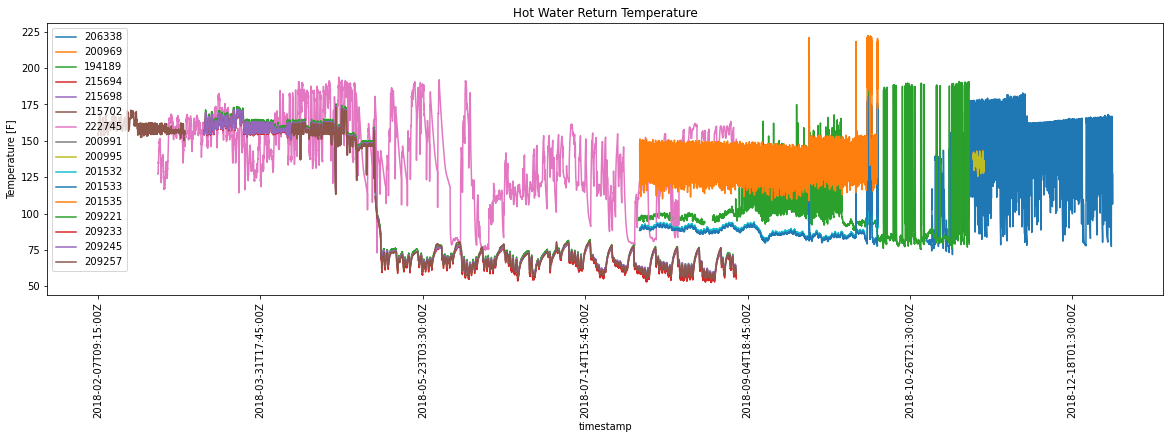

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20, 5))
sensor_data.plot(ax=ax, x="timestamp", y=sensor_data.columns.tolist()[1:], title="Hot Water Return Temperature", ylabel="Temperature [F]", rot=90)
#plt.legend(["Supply temperature", "Return temperature"])

In [ ]:
# Output csv and json
# pd.json_normalize(client.get_equipment_types()).to_csv("data/equip_types.csv")
# pd.json_normalize(client.get_all_point_types()).to_csv("data/point_types.csv")
# pd.json_normalize(client.get_all_buildings()).to_csv("data/buildings.csv")
# pd.json_normalize(client.get_all_buildings()).to_json("data/buildings.json")

In [ ]:
"""Ideas"""
"""Use case: Building Doctor"""
# cooling demand/area for each building
# counting the switches on and off for various equipment
# identify indicators for each building which represents deterioration
# benchmarking against other buildings
# build a dashboard

# select equipment
# select indicators
# rank equipment based on specific performance
